### Portfolio Assignment <br>
#### Deep Learning. Image Classification.
The work is done by Ilia Semenok. <br>

I’m a freelancer with a passion for Data Science. <br>
I was eating tomatoes the other day and I didn't like the taste. I decided to explore the origin of the problem, so I went to the store where I had <br> bought them. After speaking with the store's staff, I learned that many of their tomatoes arrive in poor condition. I decided to find the end supplier <br> in order to get closer to the root cause. After some time I managed to find the supplier, he was a farmer. We had a discussion and he explained me <br> that growing tomatoes is challenging as many tomatoes are susceptible to various diseases that need to be treated. "Manually going through the <br> farm to identify sick tomatoes and apply remedy to them is time consuming and tedious" he said. <br>
So, I proposed that I could develop a model to automatically identify tomatoes. This way he could improve his crops in quantity as well as in quality. <br> And I'd get tastier tomatoes from the shop too! We agreed that he would provide the necessary data, and with that, my work began.

He provided me with images of tomato leaves divided into 3 groups: <br> <b> early blight </b>, <b> leaf mold </b> and <b> healthy </b>.

The first two sick classes are treated differently, that's why it's important to distinguish them, while the healthy class doesn't need to be treated. <br> It's also important to not give any remedy for the healthy tomatoes as it would only deteriorate them.

So, my goal is to create a model that would correctly classify tomatoe images in 3 classes using CNN architecture. After that, the model can be <br> integrated into a scanning device that goes through all the crops and then another device would apply corresponding medicine to the ill fruits. <br>
This approach will enhance both the quality and quantity of crop yield, while greatly reducing the time needed compared to manual inspection.

The dataset was found here on TensorFlow website: <br>
https://www.tensorflow.org/datasets/catalog/plant_village <br>
The dataset was downloaded from here: <br>
https://data.mendeley.com/datasets/tywbtsjrjv/1

#### <b> Task 1 - 4. Initial Data Analysis and Preprocessing </b>

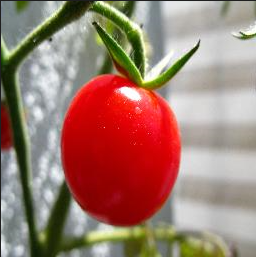

After manually investigating the photos I found this image (in 'tomato_healthy' folder) that in my opinion shouldn't be in my dataset. <br>
Other examples will follow later on, and you will see that this particular image is clearly out of place. So, I just manually deleted it.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(50)
torch.manual_seed(50)
torch.backends.cudnn.deterministic = True   # this is used to make the code reproducible.
torch.backends.cudnn.benchmark = False

I have a folder containing 3 subfolders. Each of these 3 subfolders contains images with 256x256 resolution and 3 rgb channels of colors. <br>
The main folder "PlantVillage" contains 3 subfolders: 'Tomato___Early_blight', 'Tomato___Leaf_Mold' and 'Tomato___healthy'. <br>
The total number of images: 3542. <br>
'Tomato___Early_blight': 1000, 'Tomato___Leaf_Mold': 952, 'Tomato___healthy': 1590

In [3]:
# Just checking that all images are indeed 256x256 with 3 channels in my folders.
import os
from PIL import Image

data_dir = 'PlantVillage'  # path to the folder containing the 3 subfolders with images.
all_images_correct = True  # flag to track if all images meet the requirements.

# iterate through all subfolders and images.
for subdir, _, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # open the image.
            img = Image.open(file_path)
            
            # check if the image is RGB and 256x256.
            if img.size != (256, 256) or img.mode != 'RGB':
                print(f"Image {file_path} does not meet the requirements.")
                print(f"Size: {img.size}, Mode: {img.mode}")
                all_images_correct = False
        
        except Exception as e:
            print(f"Could not process image {file_path}. Error: {e}")
            all_images_correct = False

if all_images_correct:
    print("All images are 256x256 with 3 channels (RGB).")
else:
    print("Some images did not meet the requirements.")

All images are 256x256 with 3 channels (RGB).


In [ ]:
torch.manual_seed(50)
transform = transforms.Compose([transforms.ToTensor()])  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # creating a dataloader for visualization purposes for now.
dataset.class_to_idx                                            # to see what label is assigned to what digit.

{'Tomato___Early_blight': 0, 'Tomato___Leaf_Mold': 1, 'Tomato___healthy': 2}

In [ ]:
from collections import Counter

label_counts = Counter(dataset.targets)                                                  # counting the labels for all the images.
class_counts = {dataset.classes[label]: count for label, count in label_counts.items()}  # get class names and their respective counts.
print(class_counts)
print('The total number of images:', len(dataset))

{'Tomato___Early_blight': 1000, 'Tomato___Leaf_Mold': 952, 'Tomato___healthy': 1590}
The total number of images: 3542


We can see that "healthy' class prevails over the other two. So, there is some imbalance in the dataset. <br>
I won't attempt to address this issue i will leave as it is.
#### <b> Data visualization </b>

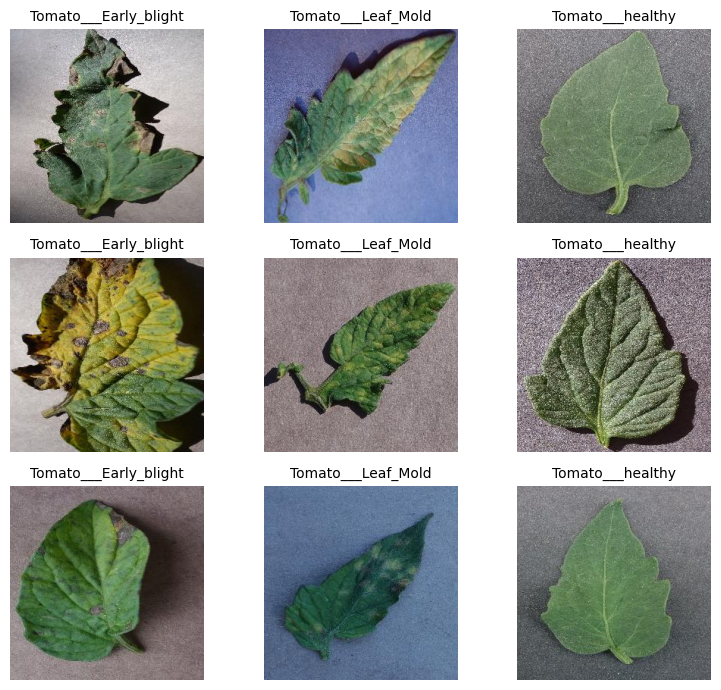

In [6]:
samples = {label: [] for label in dataset.class_to_idx.keys()}  # dictionary to hold samples.

for images, labels in data_loader:
    for img, label in zip(images, labels):
        class_name = dataset.classes[label.item()]  # retrieves the class (label) name corresponding to the index.
        if len(samples[class_name]) < 3:            # collect three images per class, cause we want 3x3 plot.
            samples[class_name].append(img)
    if all(len(v) >= 3 for v in samples.values()):  # ensures that all classes have at least 3 images.
        break

# plot the images with 3x3 grid.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))

for idx, (label, images) in enumerate(samples.items()):
    for jdx, image in enumerate(images):            # jdx is the index of the image within the class. idx - index of the class.
        ax = axes[jdx, idx]                         # to place each image in the correct position on the grid.
        img = image.numpy().transpose((1, 2, 0))    # convert tensor to numpy array and transpose it.
        ax.imshow(img)                              # to show the image.

        ax.set_title(label, fontsize=10)
        ax.axis('off')                              # to remove the axis.

plt.tight_layout()
plt.show()

Splitting the data into train (70%), valid (15%) and test (15%) and applying preprocessing. <br>
At first I compute the mean and standard deviation (std) for my train dataset and then apply it for all datasets.

In [7]:
# train valid test split and calculate mean and std.
torch.manual_seed(50)
from sklearn.model_selection import train_test_split

transform = transforms.Compose([transforms.ToTensor()])   # converts image to tensor and scales to [0, 1]
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in full_dataset.samples]

# splitting data into train and temporary dataset with stratification.
# 70% train, 30% for split between val and test.
train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=50)  

# further splitting the temp dataset into validation and test datasets with stratification.
# split temp into 50% val, 50% test -> 15%, 15% of total.
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=50)  

# creating the datasets.
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# function to calculate mean and std of the train dataset.
def calculate_mean_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])   # mean over batch, height, and width, but preserve channel.
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = ((channels_squared_sum / num_batches) - (mean ** 2)) ** 0.5

    return mean, std

# calculating mean and std using the training dataset loader only.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
mean, std = calculate_mean_std(train_loader)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4402, 0.4580, 0.4268])
Std: tensor([0.1816, 0.1660, 0.1974])


In [ ]:
# Mean: tensor([0.4402, 0.4580, 0.4268])
# Std: tensor([0.1816, 0.1660, 0.1974])

# compare with ImageNet statistics:
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]

# My mean and std are different from the ImageNet values, so I will apply my own mean and std for all my datasets.

In [8]:
# defining a new transform including normalization with the calculated mean and std.
torch.manual_seed(50)

transform_with_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

# applying the transform to each dataset.
train_dataset.dataset.transform = transform_with_norm
val_dataset.dataset.transform = transform_with_norm
test_dataset.dataset.transform = transform_with_norm

# creating DataLoaders with the new transforms.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Just ensuring that class distribution is indeed even.

def class_distribution(dataset):
    # extract the labels from the dataset.
    labels = [dataset[i][1] for i in range(len(dataset))]

    # count occurrences of each class.
    return Counter(labels)

# datasets to calculate and print class distributions.
datasets = {'Train Set': train_dataset, 'Validation Set': val_dataset, 'Test Set': test_dataset}

for name, dataset in datasets.items():
    distribution = class_distribution(dataset)
    print(f"{name} Class Distribution:")
    for label, count in sorted(distribution.items()):  # sorting by label for consistent order.
        print(f"Class {label}: {count}")
    print()  # add a newline for a better separation.

Train Set Class Distribution:
Class 0: 700
Class 1: 666
Class 2: 1113

Validation Set Class Distribution:
Class 0: 150
Class 1: 143
Class 2: 238

Test Set Class Distribution:
Class 0: 150
Class 1: 143
Class 2: 239



The validation set has one less data point in Class 2 than the test set, but it's not a big deal. <br>
Preprocessing is finally done, now we can start with applying the first simple models.

#### <b> Task 5. Baselines

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.dummy import DummyClassifier

# First we need to convert tensor type data back to regular numpy array and to flatten it as well.
def flatten_images(dataset):             # to flatten images and get labels.
    X = []
    y = []
    for img, label in dataset:
        X.append(img.view(-1).numpy())   # flatten the image.
        y.append(label)                  # get the label.
    return np.array(X), np.array(y)

# flatten datasets.
X_train, y_train = flatten_images(train_dataset)
X_val, y_val = flatten_images(val_dataset)
X_test, y_test = flatten_images(test_dataset)

def train_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    
    results = {
        'model': model_name,
        'train precision': f"{100 * precision_score(y_train, model.predict(X_train), average='macro'):.2f} %",
        'train recall': f"{100 * recall_score(y_train, model.predict(X_train), average='macro'):.2f} %",
        'valid precision': f"{100 * precision_score(y_val, model.predict(X_val), average='macro'):.2f} %",
        'valid recall': f"{100 * recall_score(y_val, model.predict(X_val), average='macro'):.2f} %",
        'test precision': f"{100 * precision_score(y_test, model.predict(X_test), average='macro'):.2f} %",
        'test recall': f"{100 * recall_score(y_test, model.predict(X_test), average='macro'):.2f} %"
    }
    return results

# models to evaluate.
models = {'Dummy': DummyClassifier(strategy='stratified', random_state=50),
          'Random Forest': RandomForestClassifier(random_state=50)}

# This specific code was improved by AI. I could've written my version, but it looks ugly and too long. This code is much more concise.
# list to store results.
results_list = [train_evaluate_model(model, name, X_train, y_train, X_val, y_val, X_test, y_test) 
                for name, model in models.items()]

In [11]:
df_baselines = pd.DataFrame(results_list)
df_baselines

,model,train precision,train recall,valid precision,valid recall,test precision,test recall
0,Dummy,32.54 %,32.54 %,33.24 %,33.23 %,34.14 %,34.16 %
1,Random Forest,100.00 %,100.00 %,89.03 %,86.65 %,89.96 %,87.41 %


We can see that Random Forest is overfitting. It shows 89.9 % and 87.4 % precision and recall respectively, which is a very good result, <br>
considering that this is an image classifiction task. <br>
Baseline model shows very poor results as expected.

I used Dummy Stratified Classifier, because i think it's a good starting choice. <br>
I chose Random Forest as my classical machine learning model. <br>
<b> "Precision" </b> and <b> "Recall" </b> were chosen as evaluation metrics, because I care about each class equally. <br>
Parameter average='macro' was specified for the same reason. I want my model to perform well across all classes.

#### <b> Task 6. Deep Learning Experiments

My CNN architecture: <br>
1) I have two convolutional layers (conv1 and conv2) with the same kernel (filter) size of 3x3, stride (sliding window) of 1 and padding of 1. <br>
The first convolutional layers has 16 filters and the second one has 32 filters. <br>
Both have ReLu activation functions after them. <br>
In this network only ReLu is used as an activation function. it introdcues non-linearity and helps to learn more complex patterns in the data.
2) Padding preserves information from the boarders, so that no information is lost. <br>
3) Both convolutional layers have "max pooling" applied to them which reduces the spatial dimensions and makes the model more robust/stable <br> to shifts in the input images. Max pooling has a 2x2 window size (kernel size) and moves two pixels at a time.
4) I have two fully connected layers fc1 and fc2. <br>
The first fully connected layer serves both as a flattening layer and a dense layer. It takes the flattened output from the previous layers: <br> 32×64×64 which is = 131072 inputs and produces 128 neurons as an output. <br>
fc1 also has a ReLu function applied to it to increase the complexity of the model. <br>
The second fully connected layer fc2 takes 128 neurons as an input and gives an output of 3 final neurons that represent our classes.
5) There is a dropout layer between fc1 and fc2. It "skips" "p" percent of the incoming 128 neurons from the fc1 layer. <br>
It's a regularization technique with a purpose to reduce overfitting.
6) CrossEntropyLoss() is used, because we have multi-class classification problem. It applies foftmax function to get probabilities <br> for the final output. It computes the loss of the predicted probability.

The code below goes through different values of dropout rate and uses early stopping mechanism to determine <br> 
the best <b> dropout rate </b> and the best <b> epoch </b> based on validation loss.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.dropout = nn.Dropout(p=dropout_rate)   # dropout layer.
        self.fc2 = nn.Linear(128, 3)                # 3 final neurons for 3 classes.

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)                # to flatten the layer.
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

dropout_rates = [0.2, 0.3, 0.4, 0.5]
num_epochs = 18
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
patience = 6

# initialize variables to track the best metrics.
best_val_loss = float('inf')            #  to track the best validation loss across all rates.
best_dropout_rate = dropout_rates[0]    #  to track the best dropout rate across all rates.
best_epoch = 0                          #  to track the epoch for the best dropout rate.
best_val_precision = 0.0                #  to track validation accuracy at the best loss.

# Iterate over each dropout rate
for dropout_rate in dropout_rates:
    print(f"\nTraining with dropout rate: {dropout_rate}")
    torch.manual_seed(50)
    model = CNN(dropout_rate=dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')          #  Initialize the best loss for this dropout rate.
    patience_counter = 0              #  Reset the patience counter for this dropout rate.
    best_epoch_for_dropout = 0        #  Initialize the best epoch for this dropout rate.
    val_precision_for_dropout = 0.0   #  Initialize valid precision for this dropout rate.

    for epoch in range(num_epochs):
        torch.manual_seed(50)
        model.train()
        running_loss = 0.0
        train_labels = []        # collect train true labels (target variable).
        train_predictions = []   # collect train predicted labels.

        for inputs, labels in train_loader:
            optimizer.zero_grad()               #  reset the gradients of model's parameters before each step.
            outputs = model(inputs)             #  perform a forward pass to get predictions.
            loss = criterion(outputs, labels)   #  calculate the loss using cross-entropy loss.
            loss.backward()                     #  perform backpropagation to compute the gradients.
            optimizer.step()                    #  update the model's parameters based on the gradients.
            running_loss += loss.item()         #  accumulate the loss for this batch.

            _, predicted = torch.max(outputs.data, 1)   # get the predicted class for each output- the index with the maximum score.
            # add true labels and predictions (convert tensors to numpy arrays for later evaluation).
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predicted.cpu().numpy())

        # calculate the average loss over all batches in this epoch.
        train_loss = running_loss / len(train_loader)

        # calculate precision for train data.
        train_precision = precision_score(train_labels, train_predictions, average='macro')

        model.eval()                                # set the model to evaluation mode.
        running_val_loss = 0.0
        all_labels = []
        all_predictions = []

        with torch.no_grad():                       # disable gradient calculation.
            for inputs, labels in val_loader:
                outputs = model(inputs)             # perform a forward pass only to get predictions.
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()     # doing the same but for valid set.
                
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        # calculate precision for validation data.
        val_precision = precision_score(all_labels, all_predictions, average='macro')

        # print metrics for the current epoch:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Precision: {100 * train_precision:.2f}%, "
              f"Valid Loss: {val_loss:.4f}, Valid Precision: {100 * val_precision:.2f}%")

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch_for_dropout = epoch + 1           # store the best epoch (1-indexed).
            val_precision_for_dropout = val_precision    # store the best valid precision for this dropout rate.
            patience_counter = 0                         # reset the counter.
            
            # update best valid loss, dropout rate and epoch if this is the lowest validation loss so far across all dropout rates.
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_dropout_rate = dropout_rate            # update the overall best dropout rate.
                best_epoch = best_epoch_for_dropout         # update the overall best epoch.
                best_val_precision = val_precision          # update the overall best validation precision.
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

    print(f"Best Epoch: {best_epoch_for_dropout} for Dropout Rate: {dropout_rate} "
          f"Valid Loss: {best_loss:.4f}, Valid Precision: {100 * val_precision_for_dropout:.2f}%")

# Final output
print(f"\nBest Dropout Rate: {best_dropout_rate} at Epoch: {best_epoch} with Valid Loss: {best_val_loss:.4f}, "
      f"Valid Precision: {100 * best_val_precision:.2f}%")


Training with dropout rate: 0.2
Epoch [1/18], Train Loss: 0.7433, Train Precision: 83.77%, Valid Loss: 0.1451, Valid Precision: 94.12%
Epoch [2/18], Train Loss: 0.0799, Train Precision: 97.02%, Valid Loss: 0.1648, Valid Precision: 95.74%
Epoch [3/18], Train Loss: 0.0412, Train Precision: 98.20%, Valid Loss: 0.1400, Valid Precision: 94.87%
Epoch [4/18], Train Loss: 0.0213, Train Precision: 99.14%, Valid Loss: 0.0558, Valid Precision: 97.92%
Epoch [5/18], Train Loss: 0.0033, Train Precision: 100.00%, Valid Loss: 0.0534, Valid Precision: 97.88%
Epoch [6/18], Train Loss: 0.0012, Train Precision: 100.00%, Valid Loss: 0.0516, Valid Precision: 97.88%
Epoch [7/18], Train Loss: 0.0005, Train Precision: 100.00%, Valid Loss: 0.0543, Valid Precision: 97.64%
Epoch [8/18], Train Loss: 0.0003, Train Precision: 100.00%, Valid Loss: 0.0548, Valid Precision: 97.64%
Epoch [9/18], Train Loss: 0.0002, Train Precision: 100.00%, Valid Loss: 0.0574, Valid Precision: 97.31%
Epoch [10/18], Train Loss: 0.0002, 

Training again the same model but now with dropout rate of 0.2 for 6 epochs. <br>
Storing loss, precision and recall for all 3 sets: train, valid and test.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "runs/experiment_1"
writer = SummaryWriter(log_dir)  # Initialize TensorBoard writer.

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.dropout = nn.Dropout(p=0.2)  # choosing 0.2 for dropout probability rate.
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
torch.manual_seed(50)
model = CNN()
num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

metrics = []  # to store metrics for train, valid, and test.

# evaluation function for valid and test sets.
def evaluate(model, epoch, data_loader, dataset_name):
    model.eval()
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')

    # Log validation/test metrics to TensorBoard
    writer.add_scalar(f'{dataset_name}/Loss', epoch_loss, epoch)
    writer.add_scalar(f'{dataset_name}/Precision', precision, epoch)
    writer.add_scalar(f'{dataset_name}/Recall', recall, epoch)

    # append metrics.
    metrics.append({
        'Epoch': epoch,
        'Loss': epoch_loss,
        'Precision': precision,
        'Recall': recall,
        'Dataset': dataset_name
    })
    
    return epoch_loss, precision, recall

# training and evaluation loop.
for epoch in range(1, num_epochs + 1):
    torch.manual_seed(50)
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_predictions = []

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    # calculate training metrics.
    train_loss = running_loss / len(train_loader)
    train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')

    # Log training metrics to TensorBoard
    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Precision', train_precision, epoch)
    writer.add_scalar('Train/Recall', train_recall, epoch)

    # store training metrics.
    metrics.append({
        'Epoch': epoch,
        'Loss': train_loss,
        'Precision': train_precision,
        'Recall': train_recall,
        'Dataset': 'Train'
    })

    # validation metrics.
    val_loss, val_precision, val_recall = evaluate(model, epoch, val_loader, 'Valid')

    # test metrics.
    test_loss, test_precision, test_recall = evaluate(model, epoch, test_loader, 'Test')

    # print metrics for the current epoch:
    print(f"Epoch {epoch}, "
          f"Train: Loss: {train_loss:.4f}, Precision: {100 * train_precision:.2f}%, Recall: {100 * train_recall:.2f}%, "
          f"Valid: Loss: {val_loss:.4f}, Precision: {100 * val_precision:.2f}%, Recall: {100 * val_recall:.2f}%, "
          f"Test: Loss: {test_loss:.4f}, Precision: {100 * test_precision:.2f}%, Recall: {100 * test_recall:.2f}%")

writer.close()  # close the TensorBoard writer after training is done.

Epoch 1, Train: Loss: 0.7433, Precision: 83.77%, Recall: 83.47%, Valid: Loss: 0.1451, Precision: 94.12%, Recall: 94.78%, Test: Loss: 0.1426, Precision: 95.32%, Recall: 95.75%
Epoch 2, Train: Loss: 0.0799, Precision: 97.02%, Recall: 96.99%, Valid: Loss: 0.1648, Precision: 95.74%, Recall: 93.46%, Test: Loss: 0.1383, Precision: 96.34%, Recall: 95.04%
Epoch 3, Train: Loss: 0.0412, Precision: 98.20%, Recall: 98.16%, Valid: Loss: 0.1400, Precision: 94.87%, Recall: 93.49%, Test: Loss: 0.1833, Precision: 94.57%, Recall: 93.03%
Epoch 4, Train: Loss: 0.0213, Precision: 99.14%, Recall: 99.12%, Valid: Loss: 0.0558, Precision: 97.92%, Recall: 97.98%, Test: Loss: 0.0661, Precision: 97.92%, Recall: 97.68%
Epoch 5, Train: Loss: 0.0033, Precision: 100.00%, Recall: 100.00%, Valid: Loss: 0.0534, Precision: 97.88%, Recall: 97.96%, Test: Loss: 0.0657, Precision: 97.48%, Recall: 97.33%
Epoch 6, Train: Loss: 0.0012, Precision: 100.00%, Recall: 100.00%, Valid: Loss: 0.0516, Precision: 97.88%, Recall: 97.96%, 

In [2]:
# %load_ext tensorboard                     # or:  %reload_ext tensorboard
# %tensorboard --logdir runs/experiment_1

In [ ]:
final_cnn_metrics = {      # just adding CNN results to my previous results from Baseline models.
    'model': 'CNN',
    'train precision': f"{100 * train_precision:.2f} %",
    'train recall': f"{100 * train_recall:.2f} %",
    'valid precision': f"{100 * val_precision:.2f} %",
    'valid recall': f"{100 * val_recall:.2f} %",
    'test precision': f"{100 * test_precision:.2f} %",
    'test recall': f"{100 * test_recall:.2f} %"
}
results_list.append(final_cnn_metrics)

In [ ]:
df_final = pd.DataFrame(results_list)
df_final

,model,train precision,train recall,valid precision,valid recall,test precision,test recall
0,Dummy,32.54 %,32.54 %,33.24 %,33.23 %,34.14 %,34.16 %
1,Random Forest,100.00 %,100.00 %,89.03 %,86.65 %,89.96 %,87.41 %
2,CNN,100.00 %,100.00 %,97.88 %,97.96 %,97.98 %,97.93 %


In [ ]:
df_final.columns = pd.MultiIndex.from_tuples([   # creating a multi indexing table for a better reading.
    ('Model', ''),
    ('Train', 'precision'), ('Train', 'recall'),
    ('Valid', 'precision'), ('Valid', 'recall'),
    ('Test', 'precision'), ('Test', 'recall')
])
df_final

Model     Train               Valid               Test         
                 precision    recall precision   recall precision   recall
0          Dummy   32.54 %   32.54 %   33.24 %  33.23 %   34.14 %  34.16 %
1  Random Forest  100.00 %  100.00 %   89.03 %  86.65 %   89.96 %  87.41 %
2            CNN  100.00 %  100.00 %   97.88 %  97.96 %   97.98 %  97.93 %

We can observe a slight overfitting in CNN model. CNN model outperforms Random Forest when it comes to the test set (and also valid set). <br>
Random Forest shows a much more overfitting in both valid and test sets. <br>
Dummy model shows terrible results.

In [16]:
df_metrics = pd.DataFrame(metrics)

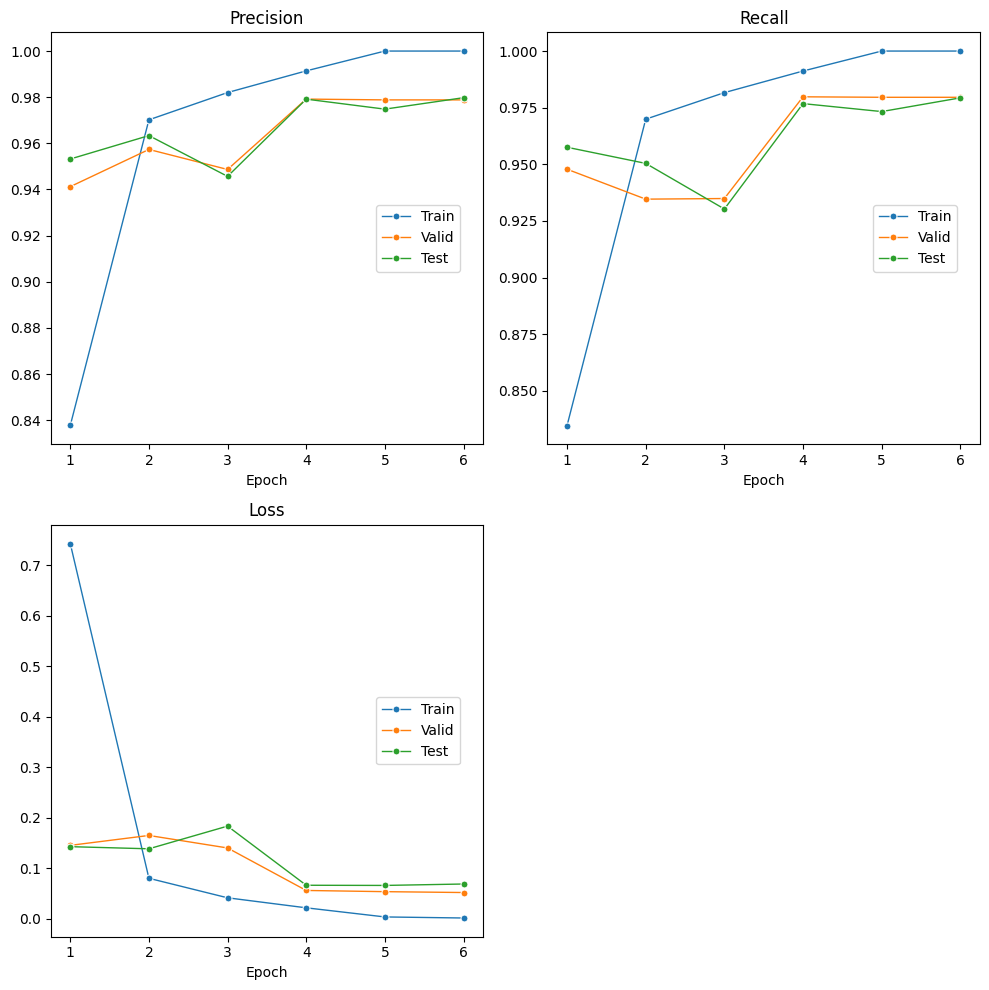

In [20]:
metrics_plot = ['Precision', 'Recall', 'Loss']               # metrics for both plotting and titles.

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # create the figure and subplots.
axs = axs.flatten()                                          # flatten the axs array for easy iteration.

# loop through metrics to create plots:
for ax, metric in zip(axs, metrics_plot):
    sns.lineplot(data=df_metrics, x='Epoch', y=metric, hue='Dataset', marker='o', markersize=5, linewidth=1, ax=ax)
    ax.set_title(metric)    # set title directly from the metric name.
    ax.set_xlabel('Epoch')
    ax.set_ylabel('')       # remove y-axis label.

    # set legend position to the middle right inside the plot.
    ax.legend(loc='center', bbox_to_anchor=(0.85, 0.5))

axs[-1].axis('off')  # hide the last empty subplot.
plt.tight_layout()
plt.show()

Somehow at the first epoch train precision and recall are much lower compared to valid and test ones. <br>
Also, at the first epoch train loss is much bigger (worse) than the valid or test loss. <br>
Valid and Test points are almost the same, which proves that the model is stable and generalizes well. <br>

Below are the same graphs but from TensorBoard. They don't look that elegant I have to say.

![tensorboard screenshot.png](<attachment:tensorboard screenshot.png>) <br>
![tensorboard screenshot2.png](<attachment:tensorboard screenshot2.png>) <br>
![tensorboard screenshot3.png](<attachment:tensorboard screenshot3.png>)
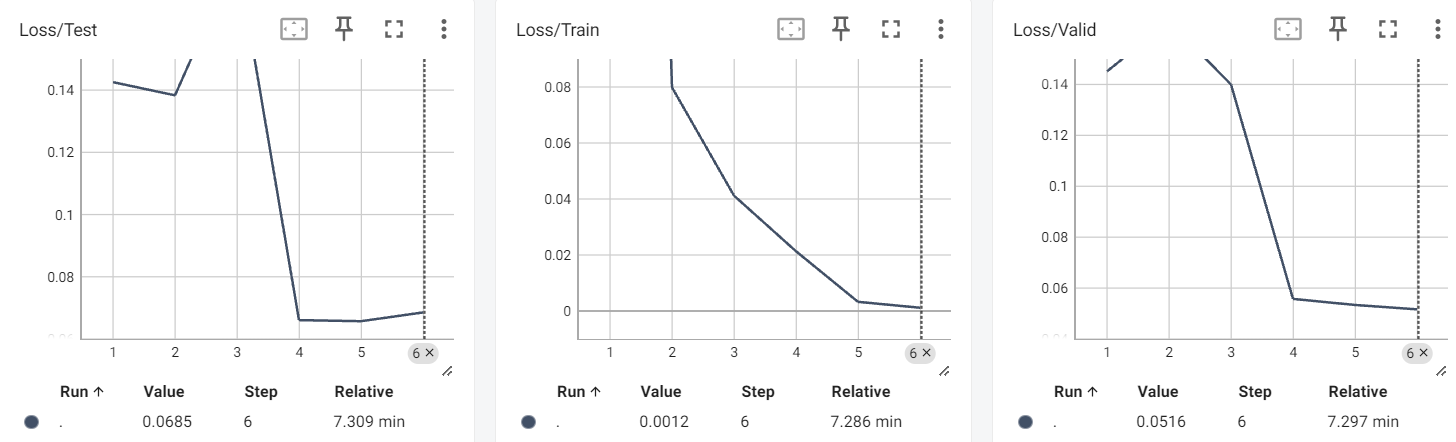
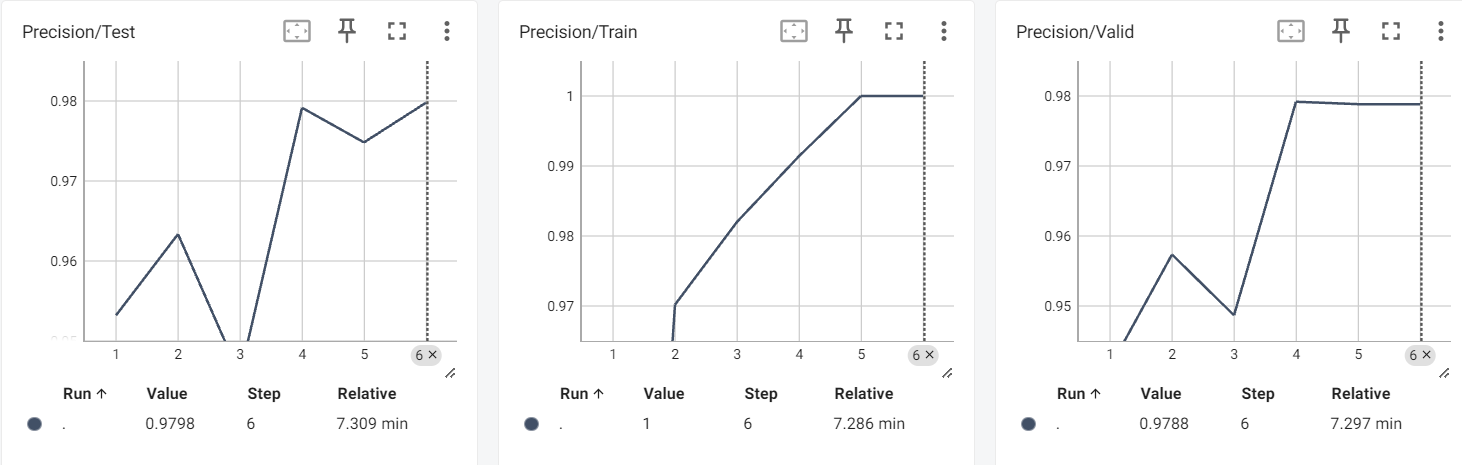
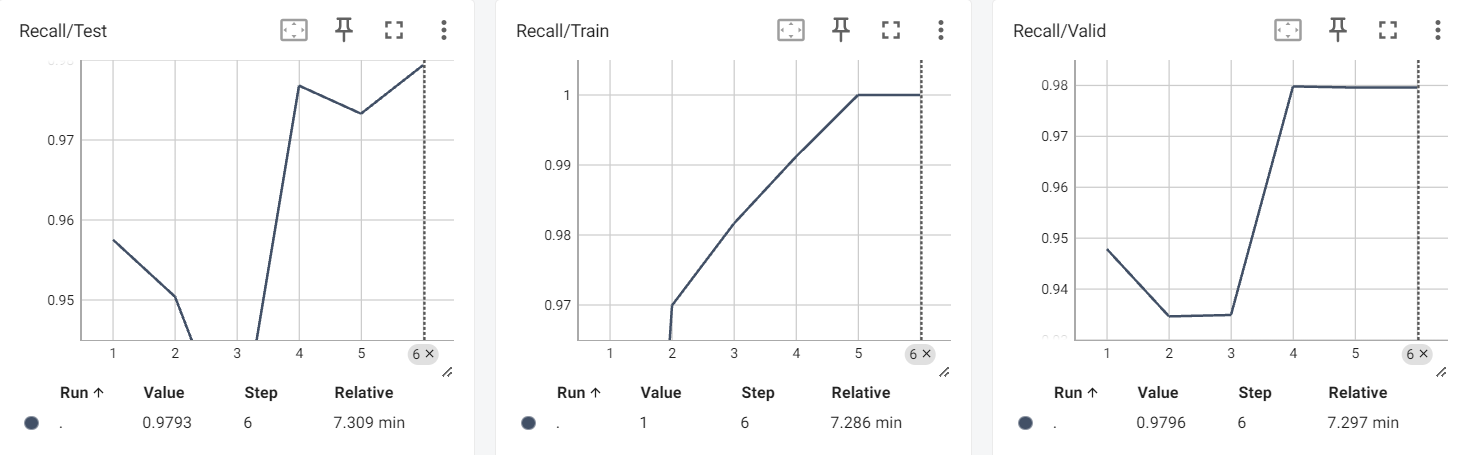

#### <b> Task 7. Conclusion and Future Work.

Deep Learning CNN model showed a better result than a classical ML Random Forest model and a Dummy Classifier. <br>
DL model has quite a good accuracy and can be implemented in real life in the farm. <br>
DL model shows a very good generalization. <br>
DL model shows a slight overfitting.

##### <b> Further actions to be carried out: </b> 
1. Set up a camera that scans tomato leaves in the farm.
2. Use some sort of object detection technique to extract tomato leaves from the video/photo.
3. Preprocess the extracted photo by resizing and normalizing it.
4. Apply my trained DL model to classify leaf image into "early blight", "leaf mold" or "healthy".
5. Apply the corresponding medicine to the diseased leaf. <br>

More images can be collected and then used to retrain the model and improve the overall accuracy.

##### <b> Limitations: </b>
DL model shows better resulsts than a simple ML model, but I didn't do any hyperparameter tuning on my Random Forest. <br>
Maybe if I did it, ML model would show better result and then it would be a question if implementing DL is necessary, given <br>
the fact that Deep Learning model requires much more resources to train. <br>
On top of that, I didn't try other models like AdaBoost, K-Nearest Neighbors (KNN), Support Vector Machine (SVM) etc. <br>
In my DL experiment I didn't use cross validation techniques, I simply made a train test split, which is not perfect. <br>
I have a feeling that my images are already nicely cropped, so that the leaf is located in the centre of the image. <br>
In other words, some preprocessing was done before my work.

##### <b> Future Work: </b>
1. However, my model could be improved if I implemented data augmentation technique. <br>
2. Cross validation can be applied. <br>
3. Techniques like focal loss or SMOTE could be used to deal with my imbalanced dataset.

##### <b> Critical Reflection: </b>
1. Of course number of neurons, filters and other parameters could be different. <br>
2. Other evaluation metrics can be used like "accuracy", "ROC-AUC". <br>
3. Since my model didn't require much epochs, I should've used a smaller learning rate and "longer" patience.
4. It might also mean that my data is quite simple and it's easy to extract the patterns from it. <br>

I believe that my goals were realistic and that I managed to achieve a good result for my intended goals. However, maybe with good tuning, the Random Forest could achieve the same results, then my deep learning model would be unnecessary.